<a href="https://colab.research.google.com/github/bannis14/Predictive_Analytics/blob/main/Facebook_Prophet_Model/Facebook_Prophet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

%cd /content/drive/MyDrive/Business Analyst course/Portfolio

/content/drive/MyDrive/Business Analyst course/Portfolio


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [5]:
# Load the dataset
df = pd.read_csv('DHS_weekly.csv')
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [6]:
# Convert 'Date' to datetime format
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y')
df.Date

0     2014-01-05
1     2014-01-12
2     2014-01-19
3     2014-01-26
4     2014-02-02
         ...    
361   2020-12-06
362   2020-12-13
363   2020-12-20
364   2020-12-27
365   2021-01-03
Name: Date, Length: 366, dtype: datetime64[ns]

In [7]:
# Rename columns for Prophet
df = df.rename(columns={'Date': 'ds', 'Total Individuals in Shelter': 'y'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848


In [8]:
# Define holiday dates
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter', 'ds': easter_dates, 'lower_window': -7, 'upper_window': 7})

In [9]:
thanksgiving_dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving', 'ds': thanksgiving_dates, 'lower_window': -7, 'upper_window': 7})

In [10]:
# Combine holidays
holidays = pd.concat([easter, thanksgiving])
holidays.head()

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7


In [11]:
# Drop holiday indicator columns
df = df.drop(columns=['Easter', 'Thanksgiving'])
df.head()

,ds,y,Christmas,Temperature
0,2014-01-05,354354,0,0.848000
1,2014-01-12,358103,0,3.257143
2,2014-01-19,359491,0,5.632857
3,2014-01-26,362880,0,-1.850000
4,2014-02-02,364125,0,1.177143


In [12]:
# Define the number of test weeks
test_weeks = 4
training = df.iloc[:-test_weeks, :]
test = df.iloc[-test_weeks:, :]

In [13]:
# Initialize the Prophet model
m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=False,
            holidays=holidays,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)

In [14]:
# Add regressors
m.add_regressor('Christmas')
m.add_regressor('Temperature')

In [15]:
# Fit the model on training data
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/279e7r3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/lmneoqgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67588', 'data', 'file=/tmp/tmp5xcn6itf/279e7r3z.json', 'init=/tmp/tmp5xcn6itf/lmneoqgc.json', 'output', 'file=/tmp/tmp5xcn6itf/prophet_modelm99en_3o/prophet_model-20231004000543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:05:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:05:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# Display regressor coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.000185,-0.000185,-0.000185
1,Temperature,multiplicative,14.934939,-0.000224,-0.000224,-0.000224


In [17]:
# Create a future dataframe for forecasting
future = m.make_future_dataframe(periods=test_weeks, freq='W')
future = pd.concat([future, df.iloc[:, 2:]], axis=1)
future

,ds,Christmas,Temperature
0,2014-01-05,0,0.848000
1,2014-01-12,0,3.257143
2,2014-01-19,0,5.632857
3,2014-01-26,0,-1.850000
4,2014-02-02,0,1.177143
...,...,...,...
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,1,7.510000


In [18]:
# Make predictions
forecast = m.predict(future)
forecast.head()
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'Temperature',
       'Temperature_lower', 'Temperature_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'thanksgiving', 'thanksgiving_lower',
       'thanksgiving_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')


In [19]:
# Display Thanksgiving holiday dates
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,thanksgiving
359,2020-11-22,0.002184
360,2020-11-29,-0.000964
361,2020-12-06,-0.003939


In [20]:
# Retrieve the predictions
predictions = forecast.yhat[-test_weeks:]
print(np.sqrt(mean_squared_error(test.y, predictions)))

84899.57374804457


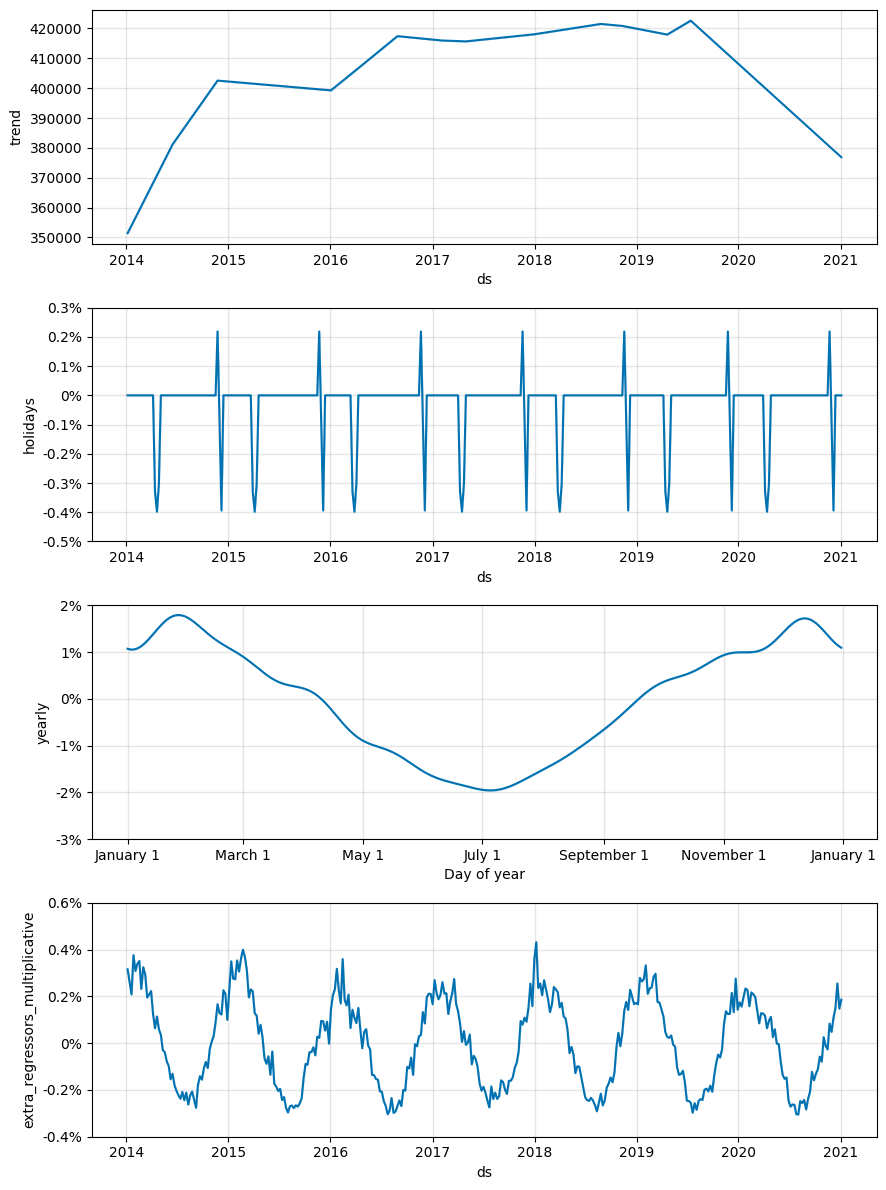

In [21]:
# Visualization
m.plot_components(forecast);

In [22]:
# Evaluate model using cross-validation
df_cv = cross_validation(m, horizon='4 W', initial='300 W', parallel='processes')
df_cv.head()
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

INFO:prophet:Making 29 forecasts with cutoffs between 2019-10-13 00:00:00 and 2020-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7dc5b3173160>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/_lshe80q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/g8tmpy3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/ia3x2w37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/49_79gql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95582', 'data', 'file=/tmp/tmp5xcn6itf/_lshe80q.json', 'init=/tmp/tmp5xcn6itf/ia3x2w37.json', 'output', 'file=/tmp/tmp5xcn6itf/prophet_model3fa6d_55/prophet_model-20231004000545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:05:45 - cmdstanpy - INFO 

8496.226901525228


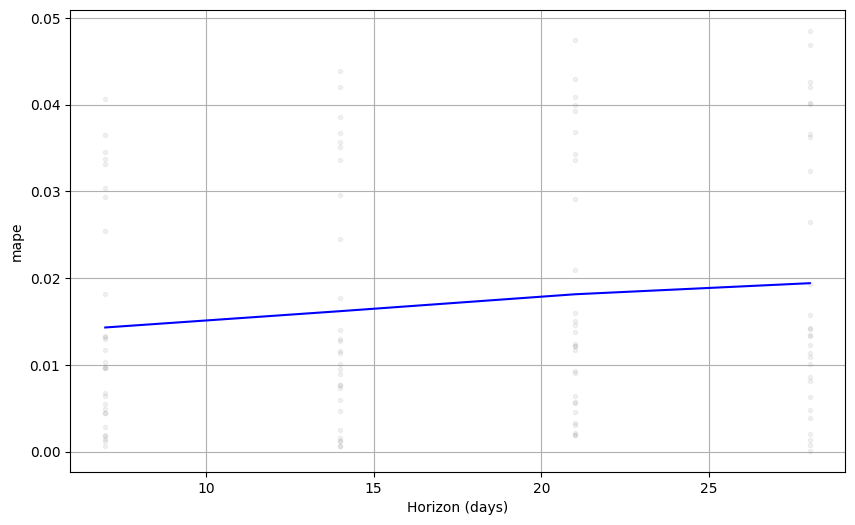

In [23]:
# Plot cross-validation metric
plot_cross_validation_metric(df_cv, metric='mape');

In [24]:
# Define parameter grid for tuning
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}

In [25]:
grid = ParameterGrid(param_grid)
len(list(grid))

54

In [26]:
rmse = []

In [27]:
# Tune model parameters
for param in grid:
    m = Prophet(growth='linear',
                yearly_seasonality=True,
                weekly_seasonality=False,
                holidays=holidays,
                seasonality_mode=param['seasonality_mode'],
                seasonality_prior_scale=param['seasonality_prior_scale'],
                holidays_prior_scale=param['holidays_prior_scale'],
                changepoint_prior_scale=param['changepoint_prior_scale'])
    m.add_regressor('Christmas')
    m.add_regressor('Temperature')
    m.fit(training)

    df_cv = cross_validation(m, horizon='4 W', initial='300 W', parallel='processes')

    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    rmse.append(error)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/b160plpg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/bq6b61cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6301', 'data', 'file=/tmp/tmp5xcn6itf/b160plpg.json', 'init=/tmp/tmp5xcn6itf/bq6b61cz.json', 'output', 'file=/tmp/tmp5xcn6itf/prophet_model4qar11z7/prophet_model-20231004001549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xcn6itf/c5dk

In [28]:
# Store tuning results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,9059.021025
1,0.01,5,additive,10,9076.092696
2,0.01,5,additive,20,9106.839260
3,0.01,5,multiplicative,5,8948.491857
4,0.01,5,multiplicative,10,9012.177870
5,0.01,5,multiplicative,20,8962.158162
6,0.01,10,additive,5,9088.853855
7,0.01,10,additive,10,9126.490148
8,0.01,10,additive,20,9085.282223
9,0.01,10,multiplicative,5,8929.634015
